## CS-E4740 - Federated Learning D (Spring 25)

# Assignment 1: ML Basics

### R. Gafur, A. Jung

<a id='varying_features'></a>
<div class="alert alert-warning">
    <h2>Deadline: 17.03.2025</h2>
</div>

<a id='learning_goals'></a>
<div class="alert alert-info">
    
## Learning Goals
<ul>
    <li> Access weather data from the Finnish Meteorological Institute (FMI).</li>
    <li> Utilize Python libraries (scikit-learn, Keras) to train basic machine learning (ML) models.</li>
    <li> Implement regularization techniques via data augmentation.</li>
</ul>

## Backround Material

- Chapter 2 of [FLBook (PDF)](https://github.com/alexjungaalto/FederatedLearning/blob/main/material/FLBook.pdf)
- optional: [Linear model implementation in scikitlearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), [Decision tree implementation in scikitlearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html), [Convolutional Neural Networks (CNN) implementation in Keras](https://www.tensorflow.org/tutorials/images/cnn)

<div class="alert alert-info">

## Loading the Data

Before performing any data preprocessing or model training, we begin by loading the dataset and conducting an initial inspection.

#### Steps:
1. **Load the dataset**: We read the weather data from a CSV file using `pandas`.
2. **Check data types**: Displaying column data types helps us understand the structure of the dataset.
3. **Inspect the first data point**: We print all feature values of the first record to get an overview of the dataset content.
4. **Check dataset dimensions**: The dataset shape is printed to determine the number of rows and columns.

</div>


In [86]:
# General libraries
import pandas as pd
import numpy as np

# Tensorflow
import tensorflow as tf  # for CNN model (tf.keras)
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv1D, Flatten, Dense
# Scikit-learn
from sklearn.tree import DecisionTreeRegressor  # for Decision Tree Regressor
from sklearn.linear_model import LinearRegression  # for Linear Regressoion
from sklearn.metrics import mean_squared_error  # to measure mean squared error (MSE)
from sklearn.preprocessing import StandardScaler  # to standardize the features

# Load the data
dataset = pd.read_csv('weather_data.csv')

# Check the data types and 
print(dataset.dtypes)
print("\n******************************\n")
print("First data point:")
print(dataset.iloc[0])
print("\n******************************\n")
print(f"Dataset Shape: {dataset.shape}")

Observation station               object
Year                               int64
Month                              int64
Day                                int64
Time [Local time]                 object
Average temperature [°C]         float64
Maximum temperature [°C]         float64
Minimum temperature [°C]         float64
Average relative humidity [%]      int64
Wind speed [m/s]                  object
Maximum wind speed [m/s]          object
Average wind direction [°]        object
Maximum gust speed [m/s]          object
Precipitation [mm]               float64
Average air pressure [hPa]       float64
dtype: object

******************************

First data point:
Observation station              Kustavi Isokari
Year                                        2023
Month                                          4
Day                                            1
Time [Local time]                          00:00
Average temperature [°C]                    -0.6
Maximum temperature [°C]  

<a id='varying_features'></a>
<div class="alert alert-info">

### Turning raw data into datapoints, characterized by features and label. 

The dataset consists of hourly weather measurements, including:  
- **Temperature**: Average, Maximum, Minimum \([°C]\)  
- **Humidity**: Average relative humidity \([\%]\)  
- **Wind**: Speed, Maximum speed, Average direction \([°]\), Maximum gust speed \([m/s]\)  
- **Precipitation**: Total precipitation \([mm]\)  
- **Air Pressure**: Average air pressure \([hPa]\)  

---
### Data Points

A data point corresponds to a specific hour, e.g., *06-April-2023 from 06:00 - 07:00*, which is recorded as `2023-04-06 06:00:00` (starting time) after preprocessing.

- **Features** include all hourly observations from the **previous 5 hours**. Example: For the data point `2023-04-06 06:00:00`, the features correspond to data from *01:00 - 06:00* on the same day.

- **Label** is the **temperature recorded 5 hours ahead**. Example: For the data point `2023-04-06 06:00:00`, the label corresponds to the temperature measured during *11:00 - 12:00*.

- **Dataset Splits**:
  - **Training Set**: Includes data from `2023-04-06 00:00:00` to `2023-04-08 00:00:00`.
  - **Validation Set**: Comprises the remaining hours of 2023.

</div>


In [87]:
# Copy the main dataset
data = dataset.copy()

# Convert specified columns to numeric (handling errors with 'coerce')
numeric_columns = [
    'Wind speed [m/s]', 
    'Maximum wind speed [m/s]', 
    'Average wind direction [°]', 
    'Maximum gust speed [m/s]'
]
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Fill missing values with 0
data.fillna(0, inplace=True)

# Create a 'timestamp' column by combining year, month, day, and local time
data['timestamp'] = pd.to_datetime(
    data['Year'].astype(str) + '-' +
    data['Month'].astype(str) + '-' +
    data['Day'].astype(str) + ' ' +
    data['Time [Local time]']
)
data['timestamp'] = data['timestamp'].astype('int64') / 1e9  # Convert to seconds as float

# Identify columns for lagged features (excluding non-relevant ones)
excluded_columns = ['Observation station', 'timestamp', 'Year', 'Month', 'Day', 'Time [Local time]']
columns_to_lag = [col for col in data.columns if col not in excluded_columns]

# Create lagged features for the previous 5 hours
for lag in range(1, 6):
    for col in columns_to_lag:
        data[f"{col} lag_{lag}"] = data[col].shift(lag)

# Define target variable (y) as the average temperature 5 hours ahead
data['y'] = data['Average temperature [°C]'].shift(-5)

# Drop rows with NaN values caused by shifts
data.dropna(inplace=True)

# Print dataset shape
print(f"Data shape: {data.shape}")

Data shape: (710, 67)


In [88]:
# Sanity checks
# Check the data rows number
assert data.shape[0] == 710, f"Unexpected number of rows: {data.shape[0]}."

print('Sanity check passed!')

Sanity check passed!


<a id='varying_features'></a>
<div class="alert alert-warning">

### 📌 TASK 1.1: Split the Data into Training and Validation Sets

#### Task Description:
1. **Split the dataset** into training (`X_train`, `y_train`) and validation (`X_val`, `y_val`) sets based on the specified time range.
2. **Training Set**: Includes data from hours `2023-04-06 00:00:00` to (and including) `2023-04-08 00:00:00`.
3. **Validation Set**: Consists of the remaining data.

#### Hints:
- Use **lagged feature columns** (i.e., columns containing `"lag"`) to create feature sets.
- Assign **lagged columns** as the feature variables for `X_train` and `X_val`.
- Use the **`y` column** as the target variable for `y_train` and `y_val`.
    
#### Points: 0.5
</div>

In [89]:

train_start = pd.to_datetime('2023-04-06 00:00:00').timestamp()  
train_end = pd.to_datetime('2023-04-08 00:00:00').timestamp() 

train_data = data[(data['timestamp'] >= train_start) & (data['timestamp'] <= train_end)]
val_data = data[data['timestamp'] > train_end]

# Split the data into training and validation sets
X_train = train_data.iloc[:,1:-1]
y_train = train_data.iloc[:,-1]
X_val = val_data.iloc[:,1:-1]
y_val = val_data.iloc[:,-1]


print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_val: {X_val.shape}, y_val: {y_val.shape}")

X_train['Time [Local time]'] = X_train['Time [Local time]'].str.split(':').apply(lambda x: float(x[0]) * 60 + float(x[1]))
X_val['Time [Local time]'] = X_val['Time [Local time]'].str.split(':').apply(lambda x: float(x[0]) * 60 + float(x[1]))



X_train: (49, 65), y_train: (49,), X_val: (546, 65), y_val: (546,)


In [90]:
# Sanity checks

# Check the data rows number
assert X_train.shape[0] == 49, f"Unexpected number of rows for X_train: {X_train.shape[0]}."
assert X_val.shape[0] == 546, f"Unexpected number of rows for X_val: {X_val.shape[0]}."

print('Sanity check passed!')

Sanity check passed!


<div class="alert alert-info">
    
### Preparing Data for Model Training: Standardization & Reproducibility

After splitting the dataset into training and validation sets, the next step is to **prepare the features** for model training. Many machine learning models, especially those based on gradient-based optimization (e.g., linear regression, neural networks), perform better when features are standardized.

#### Why Standardization?
Feature standardization ensures that all input variables:
- Have a **mean of 0** and **standard deviation of 1**, preventing features with different scales from disproportionately influencing the model.
- Enable **faster and more stable convergence** during training.

#### Steps:
1. **Standardize the Features**:
   - The `StandardScaler` from `scikit-learn` is used to transform both the training and validation datasets.
   - `fit_transform()` is applied to `X_train` to compute and apply the transformation.
   - `transform()` is applied to `X_val` to use the same scaling parameters as `X_train`, ensuring consistency.

2. **Ensure Reproducibility**:
   - To achieve consistent results across different runs, we set random seeds for both **NumPy** and **TensorFlow**.
</div>

In [91]:
# Import the required library for feature scaling
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
# This ensures that the mean is 0 and the standard deviation is 1 for each feature in X_train
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to the validation set
# We use transform() instead of fit_transform() to ensure the same scaling parameters from X_train are applied
X_val_scaled = scaler.transform(X_val)

# Set random seed for NumPy to ensure reproducibility in any random operations
np.random.seed(42)

# Set random seed for TensorFlow to ensure reproducibility in model training and initialization
tf.random.set_seed(42)
print(X_train.dtypes)

Year                                  int64
Month                                 int64
Day                                   int64
Time [Local time]                   float64
Average temperature [°C]            float64
                                     ...   
Maximum wind speed [m/s] lag_5      float64
Average wind direction [°] lag_5    float64
Maximum gust speed [m/s] lag_5      float64
Precipitation [mm] lag_5            float64
Average air pressure [hPa] lag_5    float64
Length: 65, dtype: object


<a id='varying_features'></a>
<div class="alert alert-warning">

### 📌 TASK 1.2: Linear Regression

#### Task Overview:
Now that we have **standardized** our features to ensure proper scaling, we can proceed with training our first machine learning model. In this task, you will implement and evaluate a **linear regression model** using the standardized training and validation datasets.

#### Task Instructions:
1. **Train a Linear Regression Model** using `X_train_scaled` as input features.
2. **Evaluate Model Performance** by computing the average squared error of the trained model on both the training (`X_train_scaled`,`y_train`) and validation (`X_val_scaled`,`y_val`) sets.

#### Points: 1.5
</div>

In [92]:
# model training 
# Model training 
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predictions
X_training_prediction = model.predict(X_train_scaled)  
y_validation_prediction = model.predict(X_val_scaled)  
# Evaluate the model
reg_train_error = mean_squared_error(y_train, X_training_prediction)  
reg_val_error = mean_squared_error(y_val, y_validation_prediction)

# Display results
print("\n*************** Linear Regression Diagnosis ***************")
print(f"Training Error (MSE): {reg_train_error:.4f}")
print(f"Validation Error (MSE): {reg_val_error:.4f}")



*************** Linear Regression Diagnosis ***************
Training Error (MSE): 0.0000
Validation Error (MSE): 626.9899


In [93]:
# Sanity Checks: Ensuring Correctness of Model Evaluation

# Check if computed errors are numeric values
assert isinstance(reg_train_error, float), "Error: reg_train_error must be a numeric value."
assert isinstance(reg_val_error, float), "Error: reg_val_error must be a numeric value."

print("Sanity check passed! The computed errors are valid numerical values.")


Sanity check passed! The computed errors are valid numerical values.


<a id='varying_features'></a>
<div class="alert alert-warning">

### 📌 TASK 1.3: Convolutional Neural Network (CNN)

#### Task Overview:
Now that we have trained a **linear regression model**, let's explore a more powerful approach: **a 1D Convolutional Neural Network (CNN)**. CNNs are well-suited for sequential data as they can capture local patterns and temporal dependencies.

#### Task Instructions:
1. **Implement a 1D CNN Model** using `tf.keras.Sequential` with `X_train_scaled` as input.
2. **Define the CNN architecture** with the following layers:
   - **Input Layer**: Shape `(X_train_scaled.shape[1], 1)`.
   - **Multiple Conv1D Layers** with decreasing filter sizes and `ReLU` activation.
   - **Flatten Layer** to convert feature maps into a vector.
   - **Dense Output Layer** with a single neuron for regression.
3. **Compile the Model** with:
   - **Optimizer**: Adam
   - **Loss Function**: Mean Squared Error (MSE)
4. **Train the Model** on the training set.
5. **Evaluate Model Performance** on both the training and validation sets (similar to Task 1.2).

#### Hints:
- Use `tf.keras.layers.Conv1D()` to define the convolutional layers with appropriate `filters`, `kernel_size`, and `activation`.  
- Use `tf.keras.layers.Flatten()` to reshape the convolutional output before passing it to the dense layer.  
- Use `tf.keras.layers.Dense()` for the final output layer.  
- Construct the model using `tf.keras.Sequential()`, and compile it with `model.compile()`.  

This CNN will serve as a more expressive alternative to linear regression, allowing us to compare their performances.

#### Points: 2
</div>

In [94]:

#shaping the dataset to fit conv_nn format
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val_cnn = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))

#defining our model parameters
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)  # Regression output
])

cnn_model.compile(optimizer='adam', loss='mse')
#model training
cnn_history =  cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_data=(X_val_cnn, y_val))

#perdormance evaluation
cnn_train_error = cnn_model.evaluate(X_train_cnn, y_train)
cnn_val_error = cnn_model.evaluate(X_val_cnn, y_val)

print("\n*************** Convolutional Neural Network (CNN) Diagnosis ***************")
print("Training error:", cnn_train_error)
print("Validation error:", cnn_val_error)

c:\Users\HP\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 513ms/step - loss: 1.9462 - val_loss: 5.0873
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.8419 - val_loss: 37.8258
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.4187 - val_loss: 82.3759
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.6119 - val_loss: 66.8951
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.3753 - val_loss: 34.6021
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1272 - val_loss: 16.3428
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.1089 - val_loss: 10.3025
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1514 - val_loss: 9.0252
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1574 - val_loss: 9.3576
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.1426 - val_loss: 10.3505
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1308 - val_loss: 11.1801
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.1145 

In [95]:
# Sanity checks

# Check if the variables store numeric values
assert isinstance(cnn_train_error, float), "cnn_train_error must be a numeric value."
assert isinstance(cnn_val_error, float), "cnn_val_error must be a numeric value."

print('Sanity check passed!')


Sanity check passed!


<a id='varying_features'></a>
<div class="alert alert-warning">

### 📌 TASK 1.4: Decision Tree Regressor

#### Task Overview:
Building on our previous models, we will now implement a **Decision Tree Regressor**, a non-parametric model that can capture nonlinear relationships in the data.

#### Task Instructions:
1. **Train a Decision Tree Regressor** using `X_train_scaled` as input features with `max_depth=3`.
2. **Compute Mean Squared Error (MSE)** for training (`X_train_scaled`,`y_train`) and validation (`X_val_scaled`,`y_val`) sets.

#### Points: 1.5
</div>

In [96]:
#initialising our model
dt_model = DecisionTreeRegressor(max_depth=3)

#training our model using the training data set
dt_model.fit(X_train_scaled, y_train)

# Making predictions
y_train_pred = dt_model.predict(X_train_scaled)
y_val_pred = dt_model.predict(X_val_scaled)

# Compute Mean Squared Error 
tree_train_error = mean_squared_error(y_train, y_train_pred)
tree_val_error = mean_squared_error(y_val, y_val_pred)

#Display Results

print("\n*************** Decision Tree Regressor Diagnosis ***************")
print("Training error:", tree_train_error)
print("Validation error:", tree_val_error)


*************** Decision Tree Regressor Diagnosis ***************
Training error: 0.023026774812489104
Validation error: 11.86966524350318


In [97]:
# Sanity checks

# Check if the variables store numeric values
assert isinstance(tree_train_error, float), "tree_train_error must be a numeric value."
assert isinstance(tree_val_error, float), "tree_val_error must be a numeric value."

print('Sanity check passed!')

Sanity check passed!


<div class="alert alert-info">

## Regularization 

So far, we have trained **three basic ML models**, a linear model, a CNN and a decision tree. While these models can effectively learn patterns from the training data, they are **prone to overfitting**, especially when the dataset is small. To improve generalization, we can use **regularization techniques** such as adding the **ridge penalty**.

### Implementing the Ridge Penalty with Data Augmentation  

To implement **ridge regularization**, we will:
1. **Generate an augmented training set** using independent and identically distributed (i.i.d.) **Gaussian random vectors**.
2. **Set the labels** for this augmented data to **0**.
3. **Modify our existing models** (Linear Regression, CNN, and Decision Tree) to incorporate this augmented dataset.

This approach introduces **a penalty term**, encouraging models to keep their predictions closer to zero for these artificial data points, thus improving stability and reducing overfitting.
</div>

In [134]:
import numpy as np
import pandas as pd
import tensorflow as tf

def generate_augmented_dataset(X_train, y_train, augmentation_ratio=0.5, random_seed=42):
    """
    Generates an augmented training set by adding synthetic data points drawn from a Gaussian distribution.

    Parameters:
    - X_train (numpy array or DataFrame): Original training feature set.
    - y_train (numpy array or Series): Original training labels.
    - augmentation_ratio (float): Ratio of synthetic samples to real training samples (default: 0.5).
    - random_seed (int): Random seed for reproducibility.

    Returns:
    - X_train_aug (numpy array): Augmented feature set.
    - y_train_aug (numpy array): Augmented labels (including original and synthetic samples).
    """

    # Set random seed for full reproducibility
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)  # Ensure reproducibility in TensorFlow if used later

    # Determine the number of augmented samples
    num_augmented_samples = int(augmentation_ratio * X_train.shape[0])

    print(X_train.shape[0])
    # Compute mean and standard deviation of each feature in X_train
    feature_means = np.mean(X_train, axis=0)
    feature_stds = np.std(X_train, axis=0) + 1e-8  # Small epsilon to avoid zero variance issues

    # Generate synthetic feature vectors from a Gaussian distribution
    X_augmented = np.random.normal(loc=feature_means, scale=feature_stds, size=(num_augmented_samples, X_train.shape[1]))

    # Set the labels for the augmented data points to 0
    y_augmented = np.zeros(num_augmented_samples)

    # Combine the original and augmented datasets
    X_train_aug = np.vstack((X_train, X_augmented))
    y_train_aug = np.hstack((y_train, y_augmented))

    return X_train_aug, y_train_aug

# Example usage:
# Assuming X_train_scaled and y_train are already defined
X_train_aug, y_train_aug = generate_augmented_dataset(X_train_scaled, y_train)
X_val_aug, y_val_aug = generate_augmented_dataset(X_val_scaled, y_val)


print("Original training set shape:", X_train_scaled.shape)
print("Augmented training set shape:", X_train_aug.shape)

49
546
Original training set shape: (49, 65)
Augmented training set shape: (73, 65)


<a id='regularized_models'></a>
<div class="alert alert-warning">

### 📌 TASK 1.5: Regularized Model Training with Augmented Data

In this task, you will **regularize the training** of all three models from previous tasks—**Linear Regression, CNN, and Decision Tree Regressor**—by replacing the original training set with the **augmented training set** generated above. The augmented dataset contains **synthetic feature vectors drawn from a Gaussian distribution**, with their labels set to **0**. For parametric models, using this augmented dataset to train ML a model is equivalent to adding a ridge penalty term (see Sec. 6.6. of [MLBook (PDF)](https://mlbook.cs.aalto.fi)).

#### Task Instructions:
1. **Train the following models using the augmented training set (`X_train_aug`, `y_train_aug`)**:
   - **Linear Regression**
   - **Convolutional Neural Network (CNN)**
   - **Decision Tree Regressor**
2. **Compute Mean Squared Error (MSE)** of these regularized models on the original training (`X_train_scaled`,`y_train`) and validation sets (`X_val_scaled`,`y_val`).

#### Points: 1.5
</div>

In [135]:

# Linear Regression using augmented training set
custom_reg = LinearRegression() 
custom_reg.fit(X_train_aug,y_train_aug)

X_train_prediction = custom_reg.predict(X_train_scaled)  
y_val_prediction = custom_reg.predict(X_val_scaled)  

custom_reg_train_error = mean_squared_error(y_train, X_train_prediction)  
custom_reg_val_error = mean_squared_error(y_val, y_val_prediction)

##########################

#shaping the dataset to fit conv_nn format

custom_X_train_cnn = X_train_aug.reshape((X_train_aug.shape[0], X_train_aug.shape[1], 1))
custom_X_val_cnn = X_val_aug.reshape((X_val_aug.shape[0], X_val_aug.shape[1], 1))

#defining our model parameters
custom_cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_aug.shape[1], 1)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)  # Regression output
])

custom_cnn_model.compile(optimizer='adam', loss='mse')

#model training
custom_cnn_history =  custom_cnn_model.fit(custom_X_train_cnn, y_train_aug, epochs=50, batch_size=32, validation_data=(custom_X_val_cnn, y_val_aug))

#perdormance evaluation
custom_cnn_train_error = custom_cnn_model.evaluate(custom_X_train_cnn, y_train_aug)
custom_cnn_val_error = custom_cnn_model.evaluate(custom_X_val_cnn, y_val_aug)


#############
#initialising our model
custom_dt = DecisionTreeRegressor(max_depth=3)

#training our model using the training data set
custom_dt.fit(X_train_aug, y_train_aug)

# Making predictions
custom_y_train_pred = dt_model.predict(X_train_scaled)
custom_y_val_pred = dt_model.predict(X_val_scaled)

# Compute Mean Squared Error 
custom_tree_train_error = mean_squared_error(y_train,custom_y_train_pred)
custom_tree_val_error = mean_squared_error(y_val, custom_y_val_pred)


#custom_reg_train_error = mean_squared_error(y_train, custom_reg.predict(X_train_scaled)) 
#custom_reg_val_error = mean_squared_error(y_val, custom_reg.predict(X_val_scaled)) 

print("\n*************** Diagnosis of Regularized Linear Model ***************")
print("Training error:", custom_reg_train_error)
print("Validation error:", custom_reg_val_error)

#custom_cnn_train_error = custom_cnn.evaluate(X_train_scaled[..., np.newaxis], y_train, verbose=0)
#custom_cnn_val_error = custom_cnn.evaluate(X_val_scaled[..., np.newaxis], y_val, verbose=0)

print("\n*************** Diagnosis of Regularized CNN ***************")
print("Training error:", custom_cnn_train_error)
print("Validation error:", custom_cnn_val_error)

#custom_tree_train_error = mean_squared_error(y_train, custom_tree.predict(X_train_scaled))
#custom_tree_val_error = mean_squared_error(y_val, custom_tree.predict(X_val_scaled))

print("\n*************** Diagnosis of Regularized Decision Tree ***************")
print("Training error:", custom_tree_train_error)
print("Validation error:", custom_tree_val_error)

c:\Users\HP\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 683ms/step - loss: 1.3172 - val_loss: 39.9420
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.6946 - val_loss: 22.9337
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.3983 - val_loss: 10.4810
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.3085 - val_loss: 8.5095
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.2476 - val_loss: 7.6652
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1927 - val_loss: 6.7192
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1227 - val_loss: 7.1652
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0804 - val_loss: 9.0812
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0652 - val_loss: 9.0712
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0460 - val_loss: 7.2740
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0297 - val_loss: 6.4965
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0268 - val

In [123]:
# Sanity checks

# Check if the variables store numeric values
assert isinstance(reg_train_error, float), "custom_reg_train_error must be a numeric value."
assert isinstance(reg_val_error, float), "custom_reg_val_error must be a numeric value."

# Check if the variables store numeric values
assert isinstance(cnn_train_error, float), "cnn_train_error must be a numeric value."
assert isinstance(cnn_val_error, float), "cnn_val_error must be a numeric value."

# Check if the variables store numeric values
assert isinstance(tree_train_error, float), "tree_train_error must be a numeric value."
assert isinstance(tree_val_error, float), "tree_val_error must be a numeric value."

print('Sanity check passed!')


Sanity check passed!


## Results

        Model  Training Error (Original)  Training Error (Regularized)  Validation Error (Original)  Validation Error (Regularized)
 Linear Model               3.025895e-30                      0.010870                   626.989870                     1538.150556
          CNN               3.357951e-03                      0.000096                     9.813910                        6.816176
Decision Tree               2.302677e-02                      0.023027                    11.869665                       11.869665


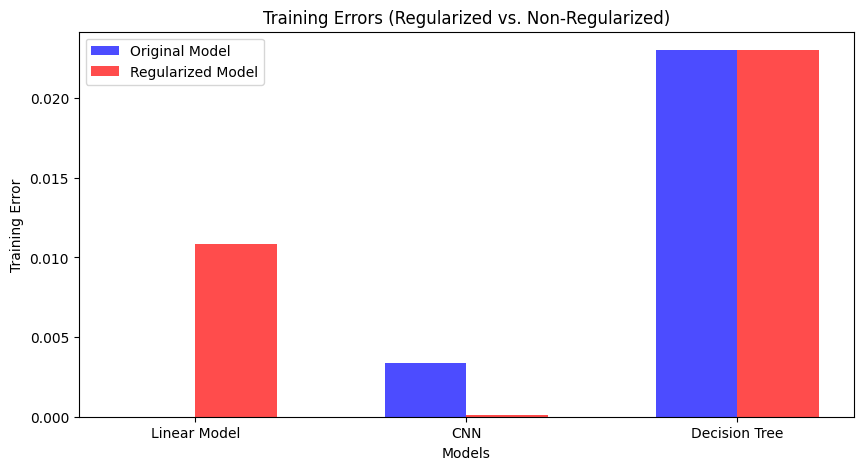

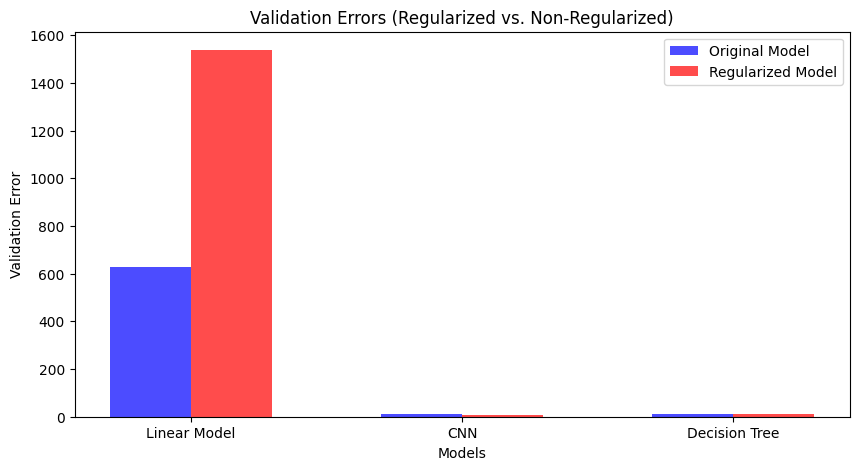

In [136]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define model names
models = ["Linear Model", "CNN", "Decision Tree"]

# Training errors
train_errors = [reg_train_error, cnn_train_error, tree_train_error]
custom_train_errors = [custom_reg_train_error, custom_cnn_train_error, custom_tree_train_error]

# Validation errors
val_errors = [reg_val_error, cnn_val_error, tree_val_error]
custom_val_errors = [custom_reg_val_error, custom_cnn_val_error, custom_tree_val_error]

# Create a DataFrame for better visualization
error_data = pd.DataFrame({
    "Model": models,
    "Training Error (Original)": train_errors,
    "Training Error (Regularized)": custom_train_errors,
    "Validation Error (Original)": val_errors,
    "Validation Error (Regularized)": custom_val_errors
})

# Print the table
print(error_data.to_string(index=False))

# Define x-axis positions for grouped bar charts
x = np.arange(len(models))  # Model positions
width = 0.3  # Bar width for better visualization

# Plot Training Errors
plt.figure(figsize=(10, 5))
plt.bar(x - width/2, train_errors, width, label='Original Model', color='blue', alpha=0.7)
plt.bar(x + width/2, custom_train_errors, width, label='Regularized Model', color='red', alpha=0.7)
plt.xlabel("Models")
plt.ylabel("Training Error")
plt.title("Training Errors (Regularized vs. Non-Regularized)")
plt.xticks(ticks=x, labels=models)
plt.legend()
plt.show()

# Plot Validation Errors
plt.figure(figsize=(10, 5))
plt.bar(x - width/2, val_errors, width, label='Original Model', color='blue', alpha=0.7)
plt.bar(x + width/2, custom_val_errors, width, label='Regularized Model', color='red', alpha=0.7)
plt.xlabel("Models")
plt.ylabel("Validation Error")
plt.title("Validation Errors (Regularized vs. Non-Regularized)")
plt.xticks(ticks=x, labels=models)
plt.legend()
plt.show()